# RandomForest

In [28]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # 정규화
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

In [ ]:
train = pd.read_csv('../dataset/train_D_U_O.csv').iloc[:,1:]
test = pd.read_csv('../dataset/test_D_U_O.csv').iloc[:,1:]
X = train.drop(['outcome_critical'], axis=1)
y = train['outcome_critical']
X_test = test.drop(['outcome_critical'], axis=1)
y_test = test['outcome_critical']
# Split dataset into training set and test set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2022) # 80% training and 20% test

## depth에 따른 최적화 찾기

In [14]:
def modeling_uncustomized (algorithm, x_train, y_train, x_test, y_test):
    # 하이퍼파라미터 조정 없이 모델 학습
    uncustomized = algorithm(random_state=1234)
    uncustomized.fit(x_train, y_train)
    # Train Data 설명력
    train_score_before = uncustomized.score(x_train, y_train).round(3)
    print(f"학습 데이터셋 정확도: {train_score_before}")
    # Test Data 설명력
    test_score_before = uncustomized.score(x_test, y_test).round(3)
    print(f"테스트 데이터셋 정확도: {test_score_before}")
    return train_score_before, test_score_before

In [16]:
def optimi_visualization(algorithm_name, x_values, train_score, test_score, xlabel, filename):
    # 하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, train_score, linestyle = '-', label = 'train score')
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, test_score, linestyle = '--', label = 'test score')
    plt.ylabel('Accuracy(%)') # y축 라벨
    plt.xlabel(xlabel) # x축 라벨
    plt.legend() # 범례표시
    plt.savefig('../figure/' + algorithm_name + '_' + filename + '.png') # 시각화한 그래프는 로컬에 저장

In [17]:
def optimi_estimator(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_estimator_min, n_estimator_max):
    train_score = []; test_score =[]
    para_n_tree = [n_tree*5 for n_tree in range(n_estimator_min, n_estimator_max)]

    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators, random_state=1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 트리 개수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore': test_score})
    # 트리 개수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator", "n_estimator")
    print(round(df_score_n, 4))

In [34]:
def optimi_maxdepth (algorithm, algorithm_name, x_train, y_train, x_test, y_test, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []
    para_depth = [depth for depth in range(depth_min, depth_max)]

    for v_max_depth in para_depth:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        # if algorithm == DTC:
        #     model = algorithm(max_depth = v_max_depth,
        #                       random_state=1234)

        model = algorithm(max_depth = v_max_depth,
                            n_estimators = n_estimator,
                            random_state=1234)
        
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 최대 깊이에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
    # 최대 깊이에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, "The number of depth", "n_depth")
    print(round(df_score_n, 4))


In [40]:
def optimi_minsplit (algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []; test_score = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    for v_min_samples_split in para_split:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링        
        model = algorithm(min_samples_split = v_min_samples_split,
                            n_estimators = n_estimator,
                            max_depth = n_depth,
                            random_state = 1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, "The minimum number of samples required to split an internal node", "min_samples_split")
    print(round(df_score_n, 4))

In [44]:
def optimi_minleaf(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        # if algorithm == DTC:
        #     model = algorithm(min_samples_leaf = v_min_samples_leaf,
        #                                 max_depth = n_depth,
        #                                 min_samples_split = n_split,
        #                                 random_state=1234)
        # else:
        model = algorithm(min_samples_leaf = v_min_samples_leaf,
                            n_estimators = n_estimator,
                            max_depth = n_depth,
                            min_samples_split = n_split,
                            random_state=1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, "The minimum number of samples required to be at a leaf node", "min_samples_leaf")
    print(round(df_score_n, 4))

In [50]:
def model_final(algorithm, algorithm_name, feature_name, x_train, y_train, x_test, y_test, n_estimator, n_depth, n_split, n_leaf):
    # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
    # else:
    model = algorithm(random_state = 1234, 
                        n_estimators = n_estimator, 
                        min_samples_leaf = n_leaf,
                        min_samples_split = n_split, 
                        max_depth = n_depth)
    # 모델 학습
    model.fit(x_train, y_train)
    # 모델 저장
    # model_path = '../model/'
    model_filename = 'wine_classification_' + algorithm_name + '.pkl'
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"최종 모델 저장 완료! 파일 경로: {model_filename}\n")
    
    # 최종 모델의 성능 평가
    train_acc = model.score(x_train, y_train)
    test_acc = model.score(x_test, y_test)
    y_pred = model.predict(x_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
    print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
    print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
    print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어
    
    # 혼동행렬 시각화
    plt.figure(figsize =(30, 30))
    plot_confusion_matrix(model, 
                         x_test, y_test,
                         include_values = True,
                         display_labels = ['Red', 'White'], # 목표변수 이름
                         cmap = 'Pastel1') # 컬러맵
    plt.savefig('../figure/' + algorithm_name + '_confusion_matrix.png') # 혼동행렬 자료 저장
    plt.show()
    
    # 변수 중요도 산출
    dt_importance = pd.DataFrame()
    dt_importance['Feature'] = feature_name # 설명변수 이름
    dt_importance['Importance'] = model.feature_importances_ # 설명변수 중요도 산출

    # 변수 중요도 내림차순 정렬
    dt_importance.sort_values("Importance", ascending = False, inplace = True)
    print(dt_importance.round(3))
    # 변수 중요도 오름차순 정렬
    dt_importance.sort_values("Importance", ascending = True, inplace = True)
    # 변수 중요도 시각화
    coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
    plt.barh(y = coordinates, width = dt_importance["Importance"])
    plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
    plt.xlabel("Feature Importance") # x축 이름
    plt.ylabel("Features") # y축 이름
    plt.savefig('../figure/' + algorithm_name + '_feature_importance.png') # 변수 중요도 그래프 저장

In [25]:
algorithm = RandomForestClassifier
algorithm_name = 'rfc'

In [27]:
train_acc_before, test_acc_before = modeling_uncustomized(algorithm, 
                                                          X_train,
                                                          y_train,
                                                          X_test,
                                                          y_test)

학습 데이터셋 정확도: 1.0
테스트 데이터셋 정확도: 0.881


In [36]:
plt.style.use(['seaborn'])

    n_estimators  TrainScore  TestScore
0              5      0.9868     0.8637
1             10      0.9951     0.8864
2             15      0.9978     0.8734
3             20      0.9989     0.8831
4             25      0.9991     0.8752
5             30      0.9995     0.8821
6             35      0.9996     0.8761
7             40      0.9997     0.8815
8             45      0.9999     0.8777
9             50      0.9999     0.8812
10            55      0.9999     0.8778
11            60      0.9999     0.8812
12            65      0.9999     0.8783
13            70      0.9999     0.8812


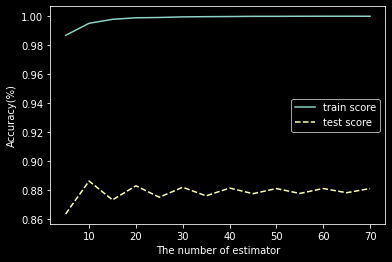

In [31]:
n_estimator_min = 1
n_estimator_max = 15
optimi_estimator(algorithm, algorithm_name, 
                X_train, y_train, X_test, y_test,
                n_estimator_min, n_estimator_max)

    depth  TrainScore  TestScore
0       1      0.7889     0.6121
1       2      0.8286     0.7087
2       3      0.8429     0.7397
3       4      0.8517     0.7503
4       5      0.8682     0.7780
5       6      0.8779     0.8037
6       7      0.8820     0.8155
7       8      0.8890     0.8292
8       9      0.8930     0.8347
9      10      0.8977     0.8436
10     11      0.9024     0.8467
11     12      0.9105     0.8530
12     13      0.9199     0.8607
13     14      0.9275     0.8649
14     15      0.9368     0.8644
15     16      0.9455     0.8680
16     17      0.9558     0.8726
17     18      0.9650     0.8719
18     19      0.9741     0.8721
19     20      0.9797     0.8738


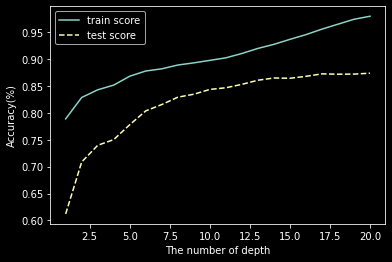

In [35]:
depth_min = 1
depth_max = 21
n_estimator = 20
optimi_maxdepth(algorithm, algorithm_name, 
                X_train, y_train, X_test, y_test, 
                depth_min, depth_max, n_estimator)

    min_samples_split  TrainScore  TestScore
0                   2      0.9797     0.8738
1                   4      0.9757     0.8755
2                   6      0.9684     0.8744
3                   8      0.9646     0.8738
4                  10      0.9605     0.8734
5                  12      0.9547     0.8724
6                  14      0.9529     0.8753
7                  16      0.9489     0.8721
8                  18      0.9465     0.8740
9                  20      0.9435     0.8713
10                 22      0.9428     0.8717
11                 24      0.9405     0.8717
12                 26      0.9366     0.8715
13                 28      0.9359     0.8706
14                 30      0.9351     0.8710
15                 32      0.9344     0.8734
16                 34      0.9329     0.8709
17                 36      0.9305     0.8722
18                 38      0.9299     0.8710
19                 40      0.9297     0.8713
20                 42      0.9272     0.8712
21        

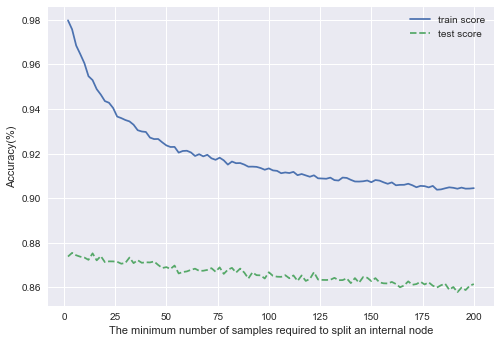

In [41]:
n_split_min = 1
n_split_max = 101
n_depth = 20
# 데이터프레임 행 최대 100개까지 반드시 출력
pd.set_option('display.max_row', 100)
optimi_minsplit (algorithm, algorithm_name,
                 X_train, y_train, X_test, y_test,
                 n_split_min, n_split_max, n_estimator, n_depth)

    min_samples_leaf  TrainScore  TestScore
0                  2      0.9690     0.8729
1                  4      0.9514     0.8730
2                  6      0.9404     0.8720
3                  8      0.9325     0.8694
4                 10      0.9282     0.8699
5                 12      0.9244     0.8702
6                 14      0.9196     0.8664
7                 16      0.9182     0.8675
8                 18      0.9167     0.8695
9                 20      0.9151     0.8666
10                22      0.9131     0.8645
11                24      0.9116     0.8635
12                26      0.9095     0.8635
13                28      0.9086     0.8616
14                30      0.9068     0.8581
15                32      0.9070     0.8627
16                34      0.9072     0.8616
17                36      0.9058     0.8617
18                38      0.9049     0.8571
19                40      0.9046     0.8585
20                42      0.9044     0.8593
21                44      0.9041

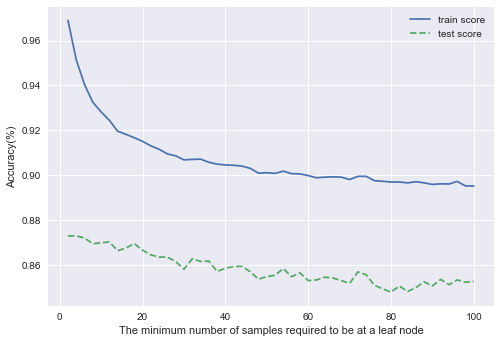

In [45]:
n_leaf_min = 1
n_leaf_max = 51
n_split = 4
optimi_minleaf(algorithm, algorithm_name, 
               X_train, y_train, X_test, y_test, 
               n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split)

최종 모델 저장 완료! 파일 경로: wine_classification_rfc.pkl

Accuracy: 0.873
Precision: 0.324
Recall: 0.858
F1-score: 0.470


c:\Users\jongm\anaconda3\envs\testdog\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 2160x2160 with 0 Axes>

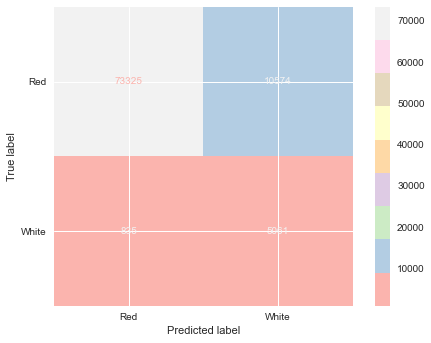

                         Feature  Importance
6                   ed_los_hours       0.222
15       outcome_hospitalization       0.195
19                 triage_acuity       0.149
8               ed_resprate_last       0.073
13                         n_med       0.061
16  outcome_inhospital_mortality       0.044
21                    triage_sbp       0.034
5              ed_heartrate_last       0.033
4                    ed_dbp_last       0.027
20               triage_resprate       0.025
0                            age       0.024
9                    ed_sbp_last       0.023
14                    n_medrecon       0.021
18                       stay_id       0.020
17                     score_CCI       0.014
7                   ed_pain_last       0.012
11                   n_hosp_365d       0.009
12                    n_icu_365d       0.004
10                        gender       0.003
2            chiefcom_chest_pain       0.003
1        chiefcom_abdominal_pain       0.002
3         

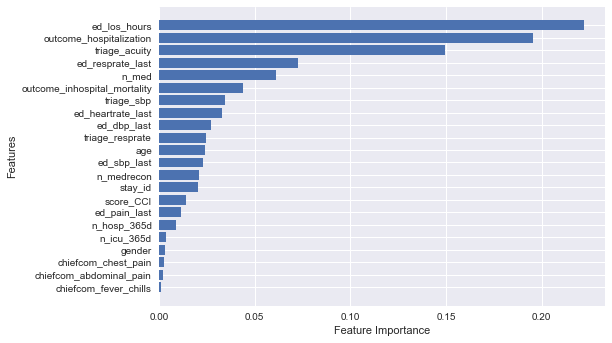

In [54]:
feature_name = X_train.columns
n_leaf = 2
model_final(algorithm, algorithm_name, feature_name,
            X_train, y_train, X_test, y_test,
            n_estimator, n_depth, n_split, n_leaf)

In [52]:
# 표준 스케일러(평균 0, 분산 1)
scaler = StandardScaler()
# 설명변수 데이터 스케일링
X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.fit_transform(X_test)

최종 모델 저장 완료! 파일 경로: wine_classification_rfc.pkl

Accuracy: 0.603
Precision: 0.142
Recall: 0.999
F1-score: 0.248


c:\Users\jongm\anaconda3\envs\testdog\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 2160x2160 with 0 Axes>

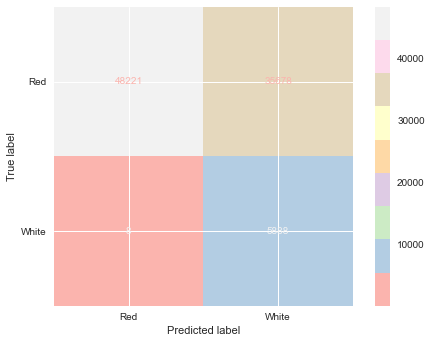

                         Feature  Importance
6                   ed_los_hours       0.222
15       outcome_hospitalization       0.195
19                 triage_acuity       0.149
8               ed_resprate_last       0.073
13                         n_med       0.061
16  outcome_inhospital_mortality       0.044
21                    triage_sbp       0.034
5              ed_heartrate_last       0.033
4                    ed_dbp_last       0.027
20               triage_resprate       0.025
0                            age       0.024
9                    ed_sbp_last       0.023
14                    n_medrecon       0.021
18                       stay_id       0.020
17                     score_CCI       0.014
7                   ed_pain_last       0.012
11                   n_hosp_365d       0.009
12                    n_icu_365d       0.004
10                        gender       0.003
2            chiefcom_chest_pain       0.003
1        chiefcom_abdominal_pain       0.002
3         

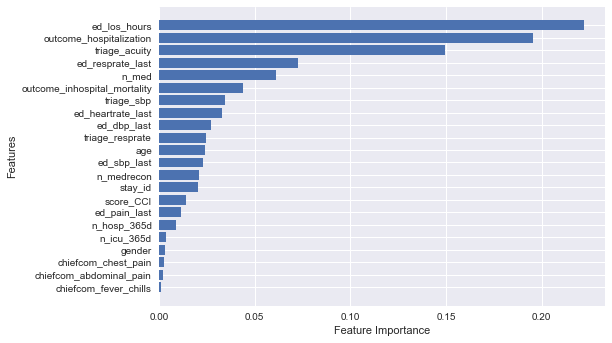

In [53]:
feature_name = X_train.columns
n_leaf = 2
model_final(algorithm, algorithm_name, feature_name,
            X_train_ss, y_train, X_test_ss, y_test,
            n_estimator, n_depth, n_split, n_leaf)

In [55]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# 설명변수 데이터 스케일링
X_train_mm = scaler.fit_transform(X_train)
X_test_mm = scaler.fit_transform(X_test)

최종 모델 저장 완료! 파일 경로: wine_classification_rfc.pkl

Accuracy: 0.867
Precision: 0.300
Recall: 0.761
F1-score: 0.430


c:\Users\jongm\anaconda3\envs\testdog\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 2160x2160 with 0 Axes>

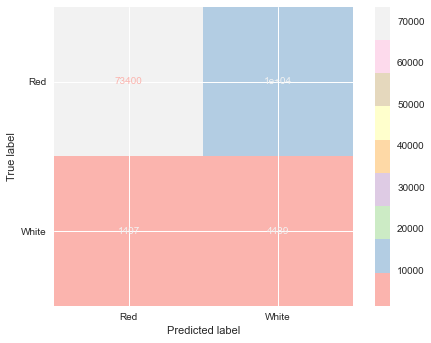

                         Feature  Importance
6                   ed_los_hours       0.222
15       outcome_hospitalization       0.195
19                 triage_acuity       0.149
8               ed_resprate_last       0.073
13                         n_med       0.061
16  outcome_inhospital_mortality       0.044
21                    triage_sbp       0.034
5              ed_heartrate_last       0.033
4                    ed_dbp_last       0.027
20               triage_resprate       0.025
0                            age       0.024
9                    ed_sbp_last       0.023
14                    n_medrecon       0.021
18                       stay_id       0.020
17                     score_CCI       0.014
7                   ed_pain_last       0.012
11                   n_hosp_365d       0.009
12                    n_icu_365d       0.004
10                        gender       0.003
2            chiefcom_chest_pain       0.003
1        chiefcom_abdominal_pain       0.002
3         

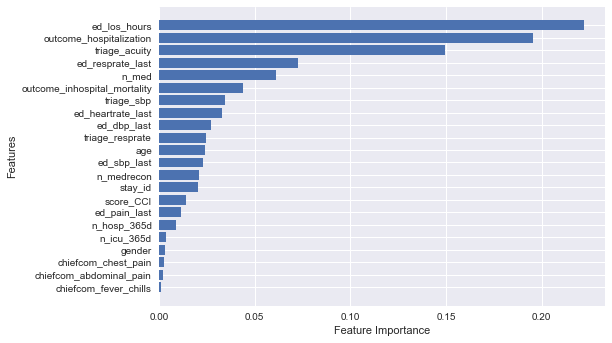

In [56]:
feature_name = X_train.columns
n_leaf = 2
model_final(algorithm, algorithm_name, feature_name,
            X_train_mm, y_train, X_test_mm, y_test,
            n_estimator, n_depth, n_split, n_leaf)

In [ ]:

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [22]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5)            # Desired number of Cross Validation folds  #n_splits값이 클수록 오래걸림
accuracies = list()
max_attributes = X_test.shape[1]
depth_range = range(1, max_attributes)

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    rand_clf = RandomForestClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    #for train_fold, valid_fold in cv.split(data):
     #   f_train = data.loc[train_fold] # Extract train data with cv indices
      #  f_valid = data.loc[valid_fold] # Extract valid data with cv indices

    model = rand_clf.fit(X_train, y_train)        
    valid_acc = model.score(X_test, y_test)        
    fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")
    
# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

KeyboardInterrupt: 

In [9]:
rand_clf = RandomForestClassifier(criterion='entropy', bootstrap=True, random_state=2022, oob_score=True)

rand_clf.fit(X_train, y_train)
pred = rand_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {:.4f}'.format(accuracy))

# print('훈련세트 정확도: {:.3f}' .format(rand_clf.score(X_train, y_train)))
# print('테스트세트 정확도: {:.3f}' .format(rand_clf.score(X_test, y_test)))

랜덤 포레스트 정확도: 0.8826


In [11]:
rand_clf.oob_score_

0.9023640942473267

Feature importances:
[0.032 0.    0.002 0.002 0.001 0.002 0.001 0.001 0.    0.001 0.001 0.002
 0.001 0.001 0.001 0.002 0.002 0.001 0.002 0.002 0.001 0.003 0.001 0.001
 0.001 0.002 0.001 0.    0.001 0.002 0.001 0.002 0.001 0.002 0.002 0.001
 0.002 0.002 0.001 0.003 0.    0.002 0.003 0.002 0.001 0.    0.002 0.002
 0.001 0.001 0.001 0.001 0.001 0.002 0.002 0.001 0.001 0.001 0.001 0.001
 0.027 0.    0.04  0.13  0.015 0.01  0.041 0.029 0.024 0.005 0.023 0.025
 0.002 0.007 0.004 0.002 0.006 0.004 0.002 0.006 0.003 0.033 0.022 0.001
 0.086 0.066 0.024 0.024 0.05  0.027 0.031 0.021 0.022 0.017 0.035 0.024]
age : 0.032
before_ed_mortality : 0.000
cci_CHF : 0.002
cci_Cancer1 : 0.002
cci_Cancer2 : 0.001
cci_DM1 : 0.002
cci_DM2 : 0.001
cci_Dementia : 0.001
cci_HIV : 0.000
cci_Liver1 : 0.001
cci_Liver2 : 0.001
cci_MI : 0.002
cci_PUD : 0.001
cci_PVD : 0.001
cci_Paralysis : 0.001
cci_Pulmonary : 0.002
cci_Renal : 0.002
cci_Rheumatic : 0.001
cci_Stroke : 0.002
chiefcom_abdominal_pain : 0.002
chiefcom_

<AxesSubplot:>

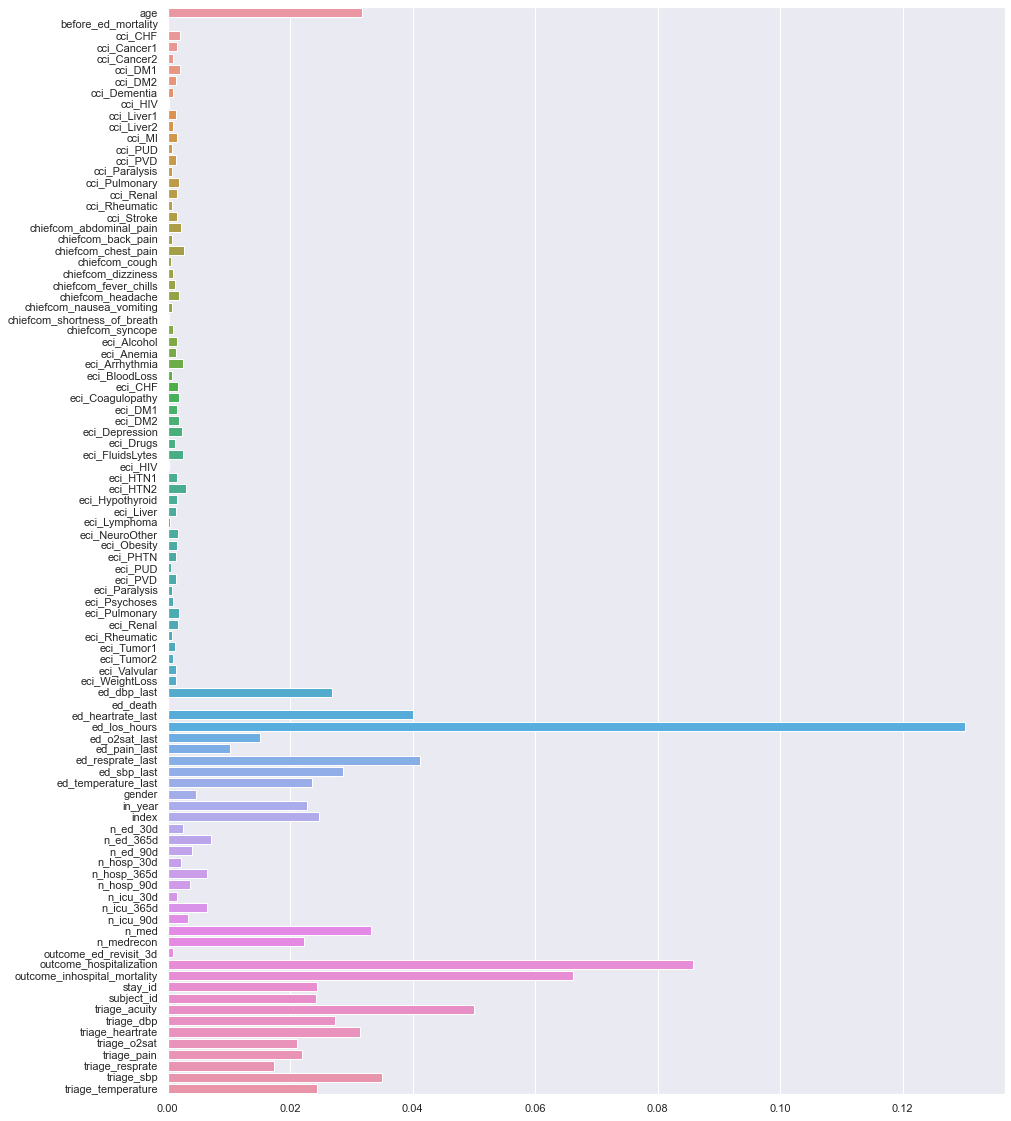

In [6]:
import seaborn as sns
import numpy as np
%matplotlib inline

# feature importance 추출 
print("Feature importances:\n{0}".format(np.round(rand_clf.feature_importances_, 3)))

# feature별 importance 매핑
for name, value in zip(X.columns , rand_clf.feature_importances_):
    print('{0} : {1:.3f}'.format(name, value))

# feature importance를 column 별로 시각화 하기 
sns.set(rc = {'figure.figsize':(15,20)})
sns.barplot(x=rand_clf.feature_importances_ , y=X.columns)